In [1]:
import json
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import scipy.stats
import numpy as np
import mpl_logoplot

/Users/s112800/Envs/epitope/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/s112800/Envs/epitope/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/s112800/Envs/epitope/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
sns.set_context('notebook',font_scale=2.0)#,rc={'savefig.bbox':'tight'})
mpl.rcParams['savefig.bbox'] = 'tight'

### Load in the data

In [3]:
with open('../bepipred3.json') as fi:
    data = json.load(fi)

### Print the length of data and the keys for the first datapoint

In [4]:
print(len(data))
print(data[0].keys())

190
dict_keys(['q3', 'seq', 'rsa', 'psi', 'method', 'phi', 'q3_prob', 'id', 'preds', 'q8', 'interface', 'asa', 'epitope', 'q8_prob', 'desc', 'disorder'])


### Print the keys and length of values for the first datapoint.

In [5]:
for key,val in data[0].items():
    print(key)
    print(len(val),type(val))

q3
444 <class 'str'>
seq
444 <class 'str'>
rsa
444 <class 'list'>
psi
444 <class 'list'>
method
7 <class 'str'>
phi
444 <class 'list'>
q3_prob
444 <class 'list'>
id
12 <class 'str'>
preds
444 <class 'list'>
q8
444 <class 'str'>
interface
444 <class 'list'>
asa
444 <class 'list'>
epitope
444 <class 'list'>
q8_prob
444 <class 'list'>
desc
11 <class 'str'>
disorder
444 <class 'list'>


### A function that extracts selected features from a JSON entry and places them in a pandas dataframe. Entries/dataframes merged into a master DF

In [6]:
#features = ['asa','disorder','epitope','interface','phi','psi','preds','rsa','q3_prob','seq']
def extractFeatures(data):
    features = ['epitope','preds','seq','desc']
    feats = list(map(lambda feat:data[feat], features))
    feats = dict(zip(features,feats))
    feats['seq'] = list(feats['seq'])
    feats['desc'] = [feats['desc']]*len(feats['preds'])
    try:
        return pd.DataFrame(feats,columns=features)
    except ValueError:
        return []

dfList = list(map(extractFeatures,data))
dfList = list(filter(lambda x:len(x)>0,dfList))#Examples of when epitope feature does not match in length???
df_master = pd.concat(dfList)

### Density plots for prediction scores, colored by the amino acid type. There is clearly a difference in means of the distributions!

In [ ]:
sns.set_palette(sns.color_palette("hls", 20))

In [ ]:
def plotAApredDistrib(df,groupCol='seq'):
    plt.figure(figsize=(8,8))
    for group in df.groupby(groupCol):
        sns.distplot(group[1].preds,hist=False,label=group[0])
    plt.legend(loc=[1.05,0],ncol=2)    
    plt.show()
    
for group in df_master.groupby('epitope'):
    print("Epitope Status: %.1f"%group[0])
    plotAApredDistrib(group[1])

### Comparing prediction score distributions for epitopes and background of amino acids.
There is also a difference in the overlap of the positive and negative distributions for amino acids. Indicating that the method is better at decerning between epitopes and background for some amino acids.

In [ ]:
def comparePosNegDistrib(df,seqCol='seq',epiCol='epitope'):
    for group in df.groupby(seqCol):
        print("Amino acid: %s"%group[0])
        for group1 in group[1].groupby(epiCol):
            sns.distplot(group1[1].preds,hist=False,label=group1[0])
        plt.show()
comparePosNegDistrib(df_master)

### Comparing mean prediction score for epitopes and background for amino acids
Every point of the scatter plot falls above the identity line, indicating that for every amino acid, the mean prediction score for epitopes is higher than for non epitopes.

In [ ]:
df_meanPred = df_master.groupby(['epitope','seq'])['preds'].mean()

#Epitope frequencies
df_freq_all = df_master.groupby(['seq'])["seq"].value_counts()

total       = len(df_master['seq'].sum())
df_freq     = df_master.groupby(['epitope','seq'])["seq"].value_counts()
total_epi   = df_freq[1].sum()
total_non   = total-total_epi

#df_epi (chance of AA being an epitope) df_intra_epi (AA distribution in the epitopes)
df_epi       = df_freq[1]/df_freq_all
df_epi       = df_epi.dropna()
df_intra_epi = df_freq[1]/total_epi
df_intra_epi = df_intra_epi.dropna()
df_intra_non = df_freq[0]/total_non
df_intra_non = df_intra_non.dropna()
df_intra_non = df_intra_non.drop('X')

df_meanPred = df_meanPred.reset_index()
df_meanPred = df_meanPred.pivot(columns='epitope',index='seq')
df_meanPred = df_meanPred.dropna()
df_meanPred['AA'] = df_meanPred.index

val = df_meanPred.values

df_meanPred['EpiFreq'] = df_epi.values
df_meanPred['EpiDistribution'] = df_intra_epi.values
df_meanPred['NonDistribution'] = df_intra_non.values
df_meanPred['Enrichment']      = [ x-y for x,y  in zip(df_intra_epi.values, df_intra_non.values) ]


plt.figure(figsize=(8,8))
for i,j,k in val:
    plt.scatter(i,j,label=k)
plt.legend(loc=[1.05,0],ncol=2)

plt.plot([0.05,0.12],[0.05,0.12])#Plot identity line for comparison
plt.title('Mean Epitope vs Non-Epitope score',size=12)
plt.show()


val = df_meanPred.values
plt.figure(figsize=(8,8))
for ele in val:
    plt.scatter(ele[1],ele[6],label=ele[2])
plt.legend(loc=[1.05,0],ncol=2)
plt.title('Mean Epitope Prediction vs. Enrichment - PCC: {:.3f}'.format(scipy.stats.pearsonr([x[1] for x in val], df_meanPred['Enrichment'])[0]), size=12)
plt.show()

df_meanPred

### Logistic regression analysis
Incomplete...

In [ ]:
def splitPartitions(df,descCol='desc',testSet=1):
    cols = df.columns
    df['part'] = list(map(lambda x:int(x.split(' ')[-1]),df[descCol].values))
    df_test = df[df['part']==testSet]
    df_train = df[df['part']!=testSet]
    return df_test[cols], df_train[cols]

df_test, df_train = splitPartitions(df_master)

In [ ]:
from sklearn.linear_model import LogisticRegression

def getData(df,xCol='preds',yCol='epitope'):
    x = df[xCol].values
    x = x.reshape(-1,1)
    y = df[yCol]
    return x,y

x_test,y_test = getData(df_test)
x_train,y_train = getData(df_train)

clf = LogisticRegression(random_state=0, solver='lbfgs',).fit(x, y)
clf.score(x, y)
pred = clf.predict(x_test)


In [ ]:
for i,j in zip(y_test,pred):
    print(i,j)

### Performance evaluation of the model
AUC10 = Area under the first 10% of the curve. Used due to the unbalance in negative (non-epitopes) and positive (epitopes) data.

In [113]:
import utils

#Setup zscores
def calc_zscores(data):
    AA_zscore = dict()
    for group in data.groupby('seq'):
        mean = group[1].preds.mean()
        stdev = group[1].preds.std()
        if np.isnan(mean):
            mean = 0.001
        if np.isnan(stdev):
            stdev = 0.001
        AA_zscore[group[0]] = [mean, stdev]
    return AA_zscore


AA_zscore = calc_zscores(df_master)

def zscore(val, mean_std):
    return (val-mean_std[0])/mean_std[1]


def model_performance(data, zscores=None, pred_weight=None):
    """Calculates performances of a model"""
    performances = {'AUC': list(), 'AUC10': list(), 'HITS': list()}
    #Combine pdbs with multiple chains
    pdbs = dict()
    combined = {'preds': list(), 'targets': list()}
    for chain in data:
        pdbid, chainid, partition = chain['desc'].split(' ')
        if pdbid != pdbs:
            pdbs[pdbid] = {'predictions': list(),'targets': list(),'aminoacid':list() }
        
        if not zscores:
            pdbs[pdbid]['predictions'].extend(chain['preds'])
            preds = chain['preds']
        else: 
            if pred_weight:
                #Amino acid Zscore used as weight on the prediction scores
                preds = [ zscore(x, zscores[chain['seq'][i]])*x for i, x in enumerate(chain['preds'])]                 
            else:
                #Predict using only Amino acid specific Zscores
                preds = [ zscore(x, zscores[chain['seq'][i]]) for i, x in enumerate(chain['preds'])] 
            
            
        combined['preds'].extend(preds)
        pdbs[pdbid]['predictions'].extend(preds)
        pdbs[pdbid]['targets'].extend(chain['epitope'])
        pdbs[pdbid]['aminoacid'].extend(list(chain['seq'])) 

        combined['targets'].extend(chain['epitope'])

    sums = {'pred':list(), 'target':list()}
    epitope_dist = { x: 0. for x in mpl_logoplot.COLORS['protein'].keys() }
    predict_dist = { x: 0. for x in mpl_logoplot.COLORS['protein'].keys() }
    hits_dist    = { x: 0. for x in mpl_logoplot.COLORS['protein'].keys() }
    for pdb in pdbs:
        
        sums['pred'].append(sum(pdbs[pdb]['predictions']))
        sums['target'].append(sum(pdbs[pdb]['targets']))
        
        epitope = ''.join(sorted([ a for t, a in zip(pdbs[pdb]['targets'], pdbs[pdb]['aminoacid']) if t == 1]))
        pdbs[pdb]['predictions'], pdbs[pdb]['targets'], pdbs[pdb]['aminoacid'] = zip(*sorted(zip(pdbs[pdb]['predictions'], pdbs[pdb]['targets'], pdbs[pdb]['aminoacid']), reverse=True))
        preds, target, amino = zip(*sorted(zip(pdbs[pdb]['predictions'], pdbs[pdb]['targets'], pdbs[pdb]['aminoacid']), reverse=True))
        #print(pdb, ''.join([ x if pdbs[pdb]['targets'][i] == 1 else x.lower() for i,x in enumerate(pdbs[pdb]['aminoacid'][:len(epitope)])]), epitope)

        for i, aa in enumerate(amino[:len(epitope)]):
            if aa == 'X': continue
            predict_dist[aa] += 1
            if target[i] == 1:
                hits_dist[aa] +=1
        
        for aa in epitope:
            if aa == 'X': continue
            epitope_dist[aa] += 1
        
        performances['HITS'].append(float(sum([ 1 if pdbs[pdb]['targets'][i] == 1 else 0 for i,x in enumerate(pdbs[pdb]['aminoacid'][:20])]))/len(epitope))
        
        auc, auc10 = utils.calc_auc(pdbs[pdb]['predictions'], pdbs[pdb]['targets'], ten=True)
        performances['AUC'].append(auc)
        performances['AUC10'].append(auc10)
    
    if not zscores:
        print('Summed predictions vs summed targets:')
        print('Mean :', np.mean(np.array(sums['pred'])), np.mean(np.array(sums['target'])))
        print('STDEV:',np.std(np.array(sums['pred'])), np.std(np.array(sums['target'])))
        print('PCC  :', scipy.stats.pearsonr(sums['pred'], sums['target'])[0])
    for measurement in sorted(performances):
        print('{}:\t{:.5f}\t{:.5f}\t{:.5f} '.format(measurement, np.mean(np.array(performances[measurement])), np.median(np.array(performances[measurement])), np.std(np.array(performances[measurement]))) )
    
    c_auc, c_auc10 = utils.calc_auc(combined['preds'], combined['targets'], ten=True)
    print('Pooled:')
    print('AUC:\t{:.5f}'.format(c_auc))
    print('AUC10:\t{:.5f}'.format(c_auc10))
    
    return epitope_dist, predict_dist, hits_dist
        
def individual_aminoacid(data, zscores):
    all_neg_preds   = list(list(data.groupby('epitope'))[0][1].preds )
    all_neg_targets = [0]*len(all_neg_preds)
    all_neg_preds_z = list(data.groupby('epitope'))[0][1]
    all_neg_preds_z = [ zscore(p, zscores[s])  for p,s in zip(all_neg_preds_z.preds, all_neg_preds_z.seq)]
    AA_performances = {'AUCs': list(),'AUC10s': list(),'AUCa': list(),'AUC10a': list(),'AUCaz': list(),'AUC10az': list() }
    for group in data.groupby('seq'):
        if group[0] == 'X': continue
        epitope_group = list(group[1].groupby('epitope'))
        aa_negatives = list(epitope_group[0][1].preds)
        aa_epitopes  = list(epitope_group[1][1].preds)

        auc_s, auc10_s = utils.calc_auc(aa_epitopes+aa_negatives, [1]*len(aa_epitopes)+[0]*len(aa_negatives), ten=True)
        AA_performances['AUCs'].append(auc_s)
        AA_performances['AUC10s'].append(auc10_s)    

        auc_a, auc10_a = utils.calc_auc(aa_epitopes+all_neg_preds, [1]*len(aa_epitopes)+all_neg_targets, ten=True)
        AA_performances['AUCa'].append(auc_a)
        AA_performances['AUC10a'].append(auc10_a)
        
        aa_epitopes_z = [ zscore(x,zscores[group[0]]) for x in aa_epitopes ]
        auc_az, auc10_az = utils.calc_auc(aa_epitopes_z+all_neg_preds_z, [1]*len(aa_epitopes)+all_neg_targets, ten=True)
        AA_performances['AUCaz'].append(auc_az)
        AA_performances['AUC10az'].append(auc10_az)
        print('{} AUCs: {:.3f}\tAUC10s: {:.3f} | AUCa: {:.3f}\tAUC10a: {:.3f} | AUCaz: {:.3f}\tAUC10az: {:.3f}'.format(group[0], auc_s,auc10_s, auc_a,auc10_a, auc_az,auc10_az))

    
    print('AVERAGE: AUCs: {:.3f}\tAUC10s: {:.3f} | AUCa: {:.3f}\tAUC10a: {:.3f} | AUCaz: {:.3f}\tAUC10az: {:.3f}'.format(np.mean(np.array(AA_performances['AUCs'])), np.mean(np.array(AA_performances['AUC10s'])),np.mean(np.array(AA_performances['AUCa'])), np.mean(np.array(AA_performances['AUC10a'])), np.mean(np.array(AA_performances['AUCaz'])), np.mean(np.array(AA_performances['AUC10az']))))

def logoplot_distribution(distribution, title='', outfile=None):
    logoplot = np.array([ distribution[aa]/sum(distribution.values()) for aa in sorted(distribution) ])
    logoplot  = np.diag(logoplot)
    #print(logoplot)
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)

    entropy = np.array([1.]*20)
    aminoacids = ''.join(sorted(mpl_logoplot.COLORS['protein'].keys()))
    mpl_logoplot.logoplot(ax, logoplot, aminoacids, height=entropy, color='protein')

    ax.set_xlabel('Amino Acids')
    ax.set_ylabel('Distribution')
    ax.set_title(title)

    fig.tight_layout()
    plt.show()
    if outfile:
        fig.savefig(outfile)
    

Original Model Performance:
Summed predictions vs summed targets:
Mean : 41.17578571493333 20.545454545454547
STDEV: 22.429849394451843 8.44551489034774
PCC  : 0.025807657277935547
AUC:	0.64141	0.65089	0.11752 
AUC10:	0.09326	0.06899	0.08568 
HITS:	0.15913	0.12500	0.13927 
Pooled:
AUC:	0.66662
AUC10:	0.10170

Zscore Model Performance:
AUC:	0.61816	0.62348	0.12233 
AUC10:	0.08640	0.06388	0.08303 
HITS:	0.15052	0.11111	0.14368 
Pooled:
AUC:	0.64859
AUC10:	0.09443

Zscore*Prediction Model Performance:
AUC:	0.60003	0.60939	0.12622 
AUC10:	0.08866	0.06478	0.08408 
HITS:	0.16116	0.12500	0.14943 
Pooled:
AUC:	0.62773
AUC10:	0.09711

Individual Amino Acid Performance:
A AUCs: 0.683	AUC10s: 0.085 | AUCa: 0.529	AUC10a: 0.019 | AUCaz: 0.674	AUC10az: 0.115
C AUCs: 0.626	AUC10s: 0.109 | AUCa: 0.411	AUC10a: 0.003 | AUCaz: 0.627	AUC10az: 0.123
D AUCs: 0.622	AUC10s: 0.088 | AUCa: 0.743	AUC10a: 0.138 | AUCaz: 0.640	AUC10az: 0.066
E AUCs: 0.589	AUC10s: 0.068 | AUCa: 0.754	AUC10a: 0.168 | AUCaz: 0.609	AU

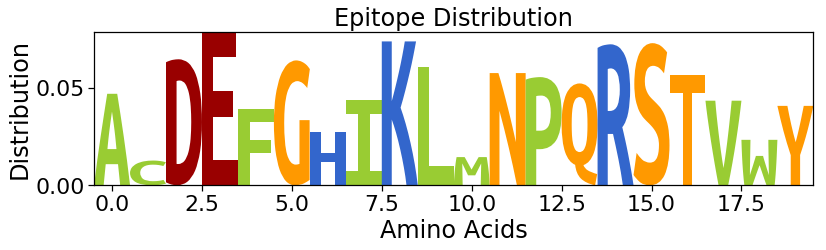

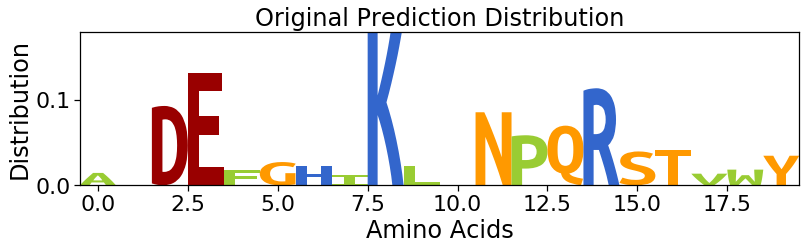

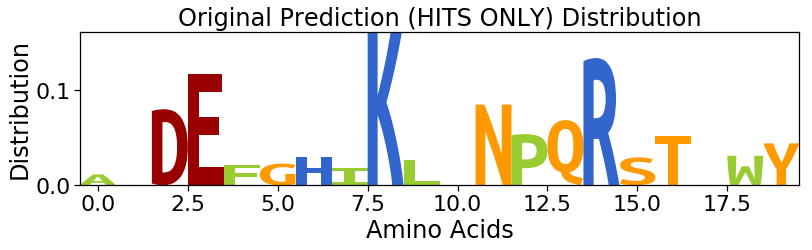

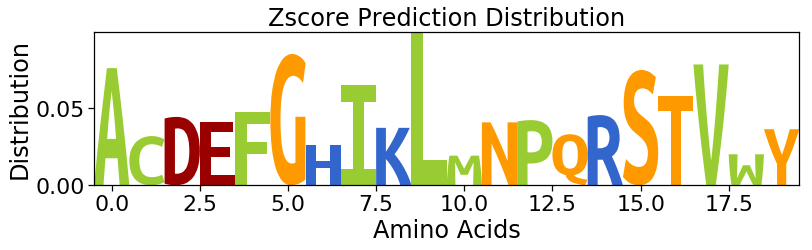

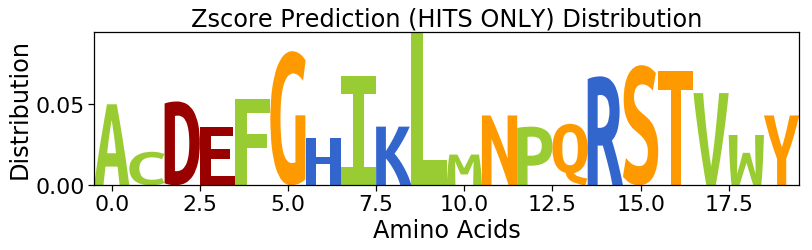

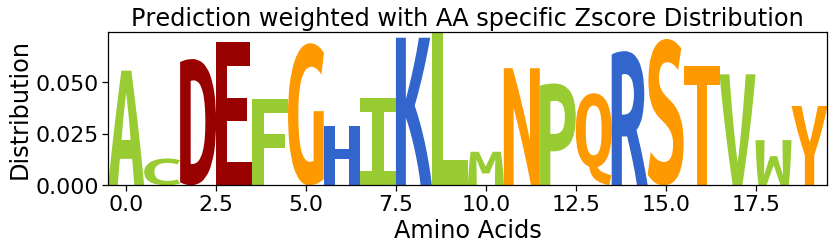

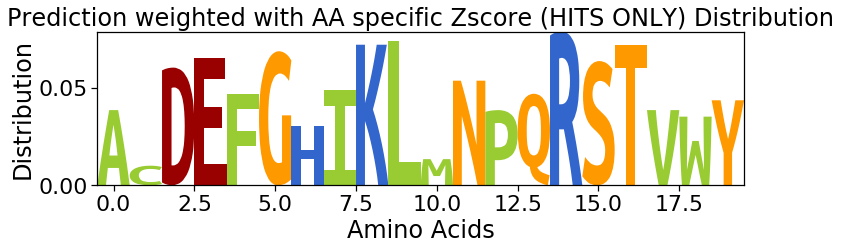

In [114]:
print('Original Model Performance:')
epitope_dist, orig_predict, orig_hits = model_performance(data)
print('')
print('Zscore Model Performance:')
epitope_dist, zscore_predict, zscore_hits = model_performance(data, zscores=AA_zscore)
print('')
print('Zscore*Prediction Model Performance:')
epitope_dist, zscore_pred_weight, zscore_hits_weight = model_performance(data, zscores=AA_zscore, pred_weight=True)
print('')

print('Individual Amino Acid Performance:')
individual_aminoacid(df_master, AA_zscore)
print('')
logoplot_distribution(epitope_dist, title='Epitope Distribution')
logoplot_distribution(orig_predict, title='Original Prediction Distribution')
logoplot_distribution(orig_hits, title='Original Prediction (HITS ONLY) Distribution')
logoplot_distribution(zscore_predict, title='Zscore Prediction Distribution')
logoplot_distribution(zscore_hits, title='Zscore Prediction (HITS ONLY) Distribution')
logoplot_distribution(zscore_pred_weight, title='Prediction * AA specific Zscore Distribution')
logoplot_distribution(zscore_hits_weight, title='Prediction * AA specific Zscore (HITS ONLY) Distribution')

In [ ]:
df_master

AminoAcids='ARNDCQEGHILKMFPSTWYVX'

AA2ind = dict(zip(list(AminoAcids),range(1,len(AminoAcids)+1)))

df_master['Ind'] = [AA2ind[AA] for AA in df_master['seq'].values]

In [ ]:
import pystan
df_master

In [ ]:
code_logit = """
data {
    int<lower=0> n_samples;
    int<lower=0,upper=1> epitope[n_samples]; // binarize to 0 or 1
    vector[n_samples] bepipred; // bepipred prediction
    vector[2] prior_means;
    matrix[2,2] prior_variances;
}
parameters {
    vector[2] params;
}
model {
    params ~ multi_normal(prior_means, prior_variances);
    epitope ~ bernoulli_logit(params[1] + params[2]*bepipred);
}
"""

sm = pystan.StanModel(model_code=code_logit)


In [ ]:
prior_means = np.array([0,0])
prior_variances = np.array([[1,0],[0,1]])

logit_dat = {'bepipred':df_master['preds'].values,
               'epitope': [int(epi) for epi in df_master['epitope'].values],
               'n_samples': len(df_master),
               'prior_means':prior_means,
               'prior_variances':prior_variances}

fit = sm.sampling(data=logit_dat, iter=1000, chains=4)

In [ ]:
params = fit.extract(permuted=False)
alpha_chains = params[:,:,0]#.mean(axis=1)
beta_chains = params[:,:,1]#.mean(axis=1)

alpha = np.reshape(alpha_chains,(-1,1))
beta = np.reshape(beta_chains,(-1,1))

plt.scatter(alpha,beta,alpha=0.2)
plt.title('Posterior Draws')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.show()

In [ ]:
anova_code = """
// Comparison of k groups with common variance (ANOVA)
data {
  int<lower=0> N; // number of data points
  int<lower=0> K; // number of groups
  int<lower=1,upper=K> x[N]; // group indicator
  vector[N] y; //
}
parameters {
  vector[K] mu;        // group means
  real<lower=0> sigma; // common std
}
model {
  y ~ normal(mu[x], sigma);
}
"""
sm_anova = pystan.StanModel(model_code=anova_code); # compile model

In [ ]:
hierarchy_code = """
data {
    int<lower=0> N; // number of data points
    int<lower=0> K; // number of groups
    int<lower=1,upper=K> x[N]; // group indicator
    vector[N] y; //
}
parameters {
  real mu0;                 // prior mean
  real<lower=0> musigma0;   // prior std
  vector[K] mu;             // group means
  real lsigma0;             // prior mean
  real<lower=0> lsigma0s;   // prior std
  vector<lower=0>[K] sigma; // group stds
}
model {
  //mu0 ~ normal(10, 10);       // weakly informative prior
  //musigma0 ~ cauchy(0,10);    // weakly informative prior
  mu ~ normal(mu0, musigma0); // population prior with unknown parameters
  //lsigma0 ~ normal(0,1);      // weakly informative prior
  //lsigma0s ~ normal(0,1);     // weakly informative prior
  sigma ~ cauchy(lsigma0, lsigma0s); // population prior with unknown parameters
  y ~ normal(mu[x], sigma[x]);
}
"""

sm_hierarchical = pystan.StanModel(model_code=hierarchy_code); # compile model

In [ ]:
dat = {'N': len(df_master),
       'K': 21,
       'x': df_master['Ind'].values,
       'y': df_master['preds'].values}

#sample_seperate = sm_anova.sampling(data=dat, iter=5000);
sample_hierarchical = sm_hierarchical.sampling(data=dat, iter=1000);


In [ ]:
sample_hierarchical['sigma'].shape

In [ ]:
df_mus = pd.DataFrame(sample_hierarchical['mu'],columns=list(AminoAcids))
for aa in list(AminoAcids):
    sns.distplot(df_mus[aa],label=aa)
plt.legend(loc=[1,0],ncol=2)
plt.show()

In [ ]:
def plot_distributions(distributions, title=''):
    """Plots distribution of the three models"""
    plt.figure(figsize=(12, 6))
    for dist in distributions:
        sns.distplot(dist[1], hist = False, kde = True,
                     kde_kws = {'linewidth': 3},
                     label = dist[0])
    
    # Plot formatting
    plt.legend(prop={'size': 16}, title = 'Models')
    plt.title(title,size=20)
    plt.xlabel('Quality Score')
    plt.ylabel('Density')
    plt.show()

def getDraws(sample,AminoAcids):
    drawList = []
    for i,a in list(AminoAcids):
        draw = np.random.normal(sample.extract()['mu'].T[i],
                                  sample.extract()['sigma'].T[i])
        drawList.append([a,draw])
    return drawList
